In [187]:
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return float(np.abs(orig - priv)/orig * 100.0)

compas = pd.read_csv('cox-violent-parsed.csv')
adult = pd.read_csv('adult_with_pii.csv')

# Columns to drop: ID, v_screening_date, in_custody, out_custody, priors_count.1, start, end, event
# This was used to remove duplicate rows that contained the same person with the same crime so that they were not counted multiple times.
compas = compas.drop(['id', 'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1', 'start', 'end', 'event'], axis=1)
compas = compas.drop_duplicates()

In [188]:
compas # id column only increments up to 11001 without the fix (technically the 11000th row, starting at 0)

,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,juv_fel_count,decile_score,juv_misd_count,juv_other_count,priors_count,days_b_screening_arrest,c_jail_in,c_jail_out,c_case_number,c_offense_date,c_arrest_date,c_days_from_compas,c_charge_degree,c_charge_desc,is_recid,r_case_number,r_charge_degree,r_days_from_arrest,r_offense_date,r_charge_desc,r_jail_in,r_jail_out,violent_recid,is_violent_recid,vr_case_number,vr_charge_degree,vr_offense_date,vr_charge_desc,type_of_assessment,decile_score.1,score_text,screening_date,v_type_of_assessment,v_decile_score,v_score_text
0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,0,1,0,0,0,-1.0,13/08/2013 6:03,14/08/2013 5:41,13011352CF10A,13/08/2013,NaN,1.0,(F3),Aggravated Assault w/Firearm,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/08/2013,Risk of Violence,1,Low
2,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,0,5,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,5,Medium,31/12/2014,Risk of Violence,2,Low
3,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,0,3,0,0,0,-1.0,26/01/2013 3:45,05/02/2013 5:36,13001275CF10A,26/01/2013,NaN,1.0,(F3),Felony Battery w/Prior Convict,1,13009779CF10A,(F3),NaN,05/07/2013,Felony Battery (Dom Strang),NaN,NaN,NaN,1,13009779CF10A,(F3),05/07/2013,Felony Battery (Dom Strang),Risk of Recidivism,3,Low,27/01/2013,Risk of Violence,1,Low
4,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,0,4,0,1,4,-1.0,13/04/2013 4:58,14/04/2013 7:02,13005330CF10A,13/04/2013,NaN,1.0,(F3),Possession of Cocaine,1,13011511MM10A,(M1),0.0,16/06/2013,Driving Under The Influence,16/06/2013,16/06/2013,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,4,Low,14/04/2013,Risk of Violence,3,Low
9,marcu brown,marcu,brown,13/01/2013,Male,21/01/1993,23,Less than 25,African-American,0,8,1,0,1,NaN,NaN,NaN,13000570CF10A,12/01/2013,NaN,1.0,(F3),Possession of Cannabis,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,8,High,13/01/2013,Risk of Violence,6,Medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18310,malcolm simmons,malcolm,simmons,01/02/2014,Male,25/03/1993,23,Less than 25,African-American,0,3,0,0,0,-1.0,31/01/2014 7:13,02/02/2014 4:03,14001422CF10A,31/01/2014,NaN,1.0,(F3),Leaving the Scene of Accident,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,3,Low,01/02/2014,Risk of Violence,5,Medium
18311,alexsandra beauchamps,alexsandra,beauchamps,29/12/2014,Female,21/12/1984,31,25 - 45,African-American,0,6,0,0,5,-1.0,28/12/2014 10:14,07/01/2015 11:42,14018106MM10A,28/12/2014,NaN,1.0,(M1),Battery,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,6,Medium,29/12/2014,Risk of Violence,4,Low
18312,winston gregory,winston,gregory,14/01/2014,Male,01/10/1958,57,Greater than 45,Other,0,1,0,0,0,-1.0,13/01/2014 5:48,14/01/2014 7:49,14000581CF10A,13/01/2014,NaN,1.0,(F2),Aggravated Battery / Pregnant,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,1,Low,14/01/2014,Risk of Violence,1,Low
18313,farrah jean,farrah,jean,09/03/2014,Female,17/11/1982,33,25 - 45,African-American,0,2,0,0,3,-1.0,08/03/2014 8:06,09/03/2014 12:18,14003308CF10A,08/03/2014,NaN,1.0,(M1),Battery on Law Enforc Officer,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,Risk of Recidivism,2,Low,09/03/2014,Risk of Violence,2,Low


# Alternative DP Definitions
The cells below compare the accuracy results of the following differentially private algorithms across the adult and COMPAS datasets.

## Renyi-Differential Privacy, Zero-Concentrated Differential Privacy, and Epsilon Delta Differential Privacy

(array([  14., 2401., 1472., 1179., 1132.,  972.,  930.,  843.,  750.,
        1308.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <BarContainer object of 10 artists>)

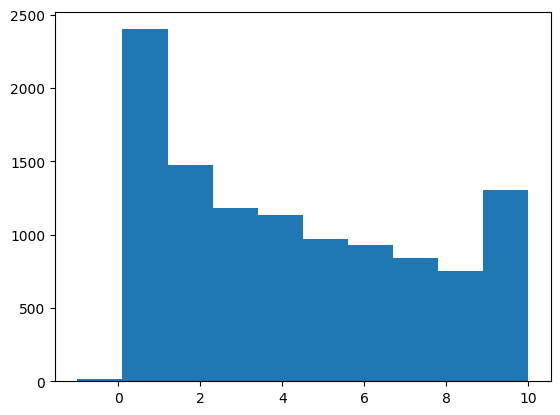

In [189]:
# decile_score includes ALL of the recorded risk scores
# v_decile_score is just violent risk scores
plt.hist(compas['decile_score'], bins=10)

### Synthetic Representation
Creating a synthetic representation used to create synthetic data for testing

In [190]:
# Getting a synthetic representation of the overall decile_score data
def noisy_score_hist(dataset, sensitivity, epsilon):
    hist = dataset.value_counts()
    # Parallel composition applies because it is a histogram
    return hist.apply(lambda x: laplace_mech(x, sensitivity, epsilon))

(array([  14., 2401., 1472., 1179., 1132.,  972.,  930.,  843.,  750.,
        1308.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <BarContainer object of 10 artists>)

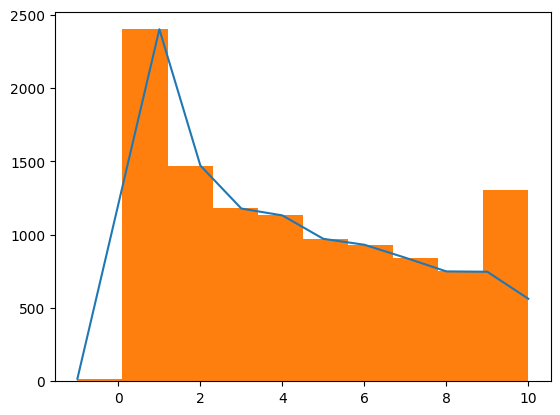

In [191]:
# Line representing synthetic rep.
plt.plot(noisy_score_hist(compas['decile_score'], 1, 1.0).sort_index());
# Actual data
plt.hist(compas['decile_score'], bins=10)

In [192]:
# Create a one-way marginal based on any column in the compas dataset
def dp_one_way_marginal(dataset, col, sensitivity, epsilon):
    hist = dataset[col].value_counts()
    hist = hist.apply(lambda x: laplace_mech(x, sensitivity, epsilon))
    
    syn_rep = hist
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    return syn_normalized #.to_frame(name='probability').reset_index()

In [193]:
# Set sensitivity = 1 because people can only have one row in our dataset after pre-processing
dp_one_way_marginal(compas, 'decile_score', 1, 1.0).to_frame().reset_index()

,decile_score,count
0,1,0.218265
1,2,0.133724
2,3,0.107320
3,4,0.102908
4,5,0.088369
5,6,0.084713
6,7,0.076608
7,8,0.067925
8,9,0.067716
9,10,0.051249


In [194]:
# Renyi-Differential Privacy Algorithm
# credit to Joe Near for python implementation
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)

# Epsilon-Delta Algorithm
def gaussian_mech_EDP(val, sensitivity, epsilon, delta):
    return val + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

# zero-Concentrated Algorithm
def gaussian_mech_zCDP(val, sensitivity, rho):
    sigma = np.sqrt((sensitivity**2 / (2*rho)))
    return val + np.random.normal(loc=0, scale=sigma)

# RDP Vector Implementation
def gaussian_mech_vec_RDP(vec, sensitivity, alpha, epsilon):
    return [gaussian_mech_RDP(v, sensitivity=sensitivity, alpha=alpha, epsilon=epsilon/len(vec)) for v in vec]

# RDP Epsilon -> Epsilon Delta Epsilon
def rdp_convert(alpha, epsilon_bar, delta):
    return epsilon_bar + np.log(1/delta) / (alpha-1)

# zCDP Convert -> Epsilon Delta Epsilon
def zcdp_convert(rho, delta):
    return rho + 2 * np.sqrt(rho * np.log(1/delta))

Index(['name', 'first', 'last', 'compas_screening_date', 'sex', 'dob', 'age',
       'age_cat', 'race', 'juv_fel_count', 'decile_score', 'juv_misd_count',
       'juv_other_count', 'priors_count', 'days_b_screening_arrest',
       'c_jail_in', 'c_jail_out', 'c_case_number', 'c_offense_date',
       'c_arrest_date', 'c_days_from_compas', 'c_charge_degree',
       'c_charge_desc', 'is_recid', 'r_case_number', 'r_charge_degree',
       'r_days_from_arrest', 'r_offense_date', 'r_charge_desc', 'r_jail_in',
       'r_jail_out', 'violent_recid', 'is_violent_recid', 'vr_case_number',
       'vr_charge_degree', 'vr_offense_date', 'vr_charge_desc',
       'type_of_assessment', 'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text'],
      dtype='object')

### Summation

In [168]:
def rdp_sum(dataset, sensitivity, alpha, epsilon):
    clipped_data = dataset.clip(upper=sensitivity)
    # run the query and return the result
    return gaussian_mech_RDP(sum(clipped_data), sensitivity=sensitivity, alpha=alpha, epsilon=epsilon)

def edp_sum(dataset, sensitivity, epsilon, delta):
    clipped_data = dataset.clip(upper=sensitivity)
    # run the query and return the result
    return gaussian_mech_EDP(sum(clipped_data), sensitivity=sensitivity, epsilon=epsilon, delta=delta)

def zcdp_sum(dataset, sensitivity, rho):
    clipped_data = dataset.clip(upper=sensitivity)
    # run the query and return the result
    return gaussian_mech_zCDP(sum(clipped_data), sensitivity=sensitivity, rho=rho)

In [169]:
epsilon = .01
alpha = 5
delta = 1e-5
rho = .0001
b_adult = 100
b_compas = 100

# Run Tests Here
# Adult Dataset
adult_real_results = adult['Age'].sum()
adult_edp_results = [edp_sum(adult['Age'],sensitivity=b_adult,epsilon=epsilon,delta=delta) for _ in range(100)]
adult_rdp_results = [rdp_sum(adult['Age'],sensitivity=b_adult,alpha=alpha,epsilon=epsilon) for _ in range(100)]
adult_zcdp_results = [zcdp_sum(adult['Age'],sensitivity=b_adult,rho=rho) for _ in range(100)]

# COMPAS Dataset
compas_real_results = compas['age'].sum()
compas_edp_results = [edp_sum(compas['age'],sensitivity=b_compas,epsilon=epsilon,delta=delta) for _ in range(100)]
compas_rdp_results = [rdp_sum(compas['age'],sensitivity=b_compas,alpha=alpha,epsilon=epsilon) for _ in range(100)]
compas_zcdp_results = [zcdp_sum(compas['age'],sensitivity=b_compas,rho=rho) for _ in range(100)]


# Error Results
adult_edp_error = np.sum([pct_error(adult_real_results, result) for result in adult_edp_results])/100
adult_rdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_rdp_results])/100
adult_zcdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_zcdp_results])/100
compas_edp_error = np.sum([pct_error(compas_real_results, result) for result in compas_edp_results])/100
compas_rdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_rdp_results])/100
compas_zcdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_zcdp_results])/100

print("Adult Dataset:")
print("Adult Epsilon-Delta Error:",adult_edp_error)
print("Adult Renyi Error:",adult_rdp_error)
print("Adult Zero-Concentrated Error:",adult_zcdp_error)
print("Compas Dataset:")
print("COMPAS Epsilon-Delta Error:",compas_edp_error)
print("COMPAS Renyi Error:",compas_rdp_error)
print("COMPAS Zero-Concentrated Error:",compas_zcdp_error)

Adult Dataset:
Adult Epsilon-Delta Error: 3.235303371567194
Adult Renyi Error: 0.09888372712980922
Adult Zero-Concentrated Error: 0.5407470032235926
Compas Dataset:
COMPAS Epsilon-Delta Error: 85.31869922110776
COMPAS Renyi Error: 3.4007603449180874
COMPAS Zero-Concentrated Error: 13.08262853291979


### Count

In [170]:
def gaussian_mech_RDP(val, sensitivity, alpha, epsilon):
    sigma = np.sqrt((sensitivity**2 * alpha) / (2 * epsilon))
    return val + np.random.normal(loc=0, scale=sigma)
    
def rdp_count(dataset, sensitivity, alpha, epsilon):
    return gaussian_mech_RDP(dataset, sensitivity=sensitivity, alpha=alpha, epsilon=epsilon)

def edp_count(dataset, sensitivity, epsilon, delta):
    return gaussian_mech_EDP(dataset, sensitivity=sensitivity, epsilon=epsilon, delta=delta)

def zcdp_count(dataset, sensitivity, rho):
    return gaussian_mech_zCDP(dataset, sensitivity=sensitivity, rho=rho)

In [171]:
epsilon = .01
alpha = 5
delta = 1e-5
rho = .0001
b_adult = 1
b_compas = 1

# Run Tests Here
# Adult Dataset
adult_real_results = int(adult['Age'].count())
adult_rdp_results = [rdp_count(adult_real_results,sensitivity=b_adult,alpha=alpha,epsilon=epsilon) for _ in range(100)]
adult_edp_results = [edp_count(adult_real_results,sensitivity=b_adult,epsilon=epsilon,delta=delta) for _ in range(100)]
adult_zcdp_results = [zcdp_count(adult_real_results,sensitivity=b_adult,rho=rho) for _ in range(100)]

adult_rdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_rdp_results])/100
adult_edp_error = np.sum([pct_error(adult_real_results, result) for result in adult_edp_results])/100
adult_zcdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_zcdp_results])/100

# COMPAS Dataset
compas_real_results = int(compas['age'].count())
compas_edp_results = [edp_count(compas_real_results,sensitivity=b_compas,epsilon=epsilon,delta=delta) for _ in range(100)]
compas_rdp_results = [rdp_count(compas_real_results,sensitivity=b_compas,alpha=alpha,epsilon=epsilon) for _ in range(100)]
compas_zcdp_results = [zcdp_count(compas_real_results,sensitivity=b_compas,rho=rho) for _ in range(100)]

compas_edp_error = np.sum([pct_error(compas_real_results, result) for result in compas_edp_results])/100
compas_rdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_rdp_results])/100
compas_zcdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_zcdp_results])/100

print("Adult Dataset:")
print("Adult Epsilon-Delta Error:",adult_edp_error)
print("Adult Renyi Error:",adult_rdp_error)
print("Adult Zero-Concentrated Error:",adult_zcdp_error)
print("Compas Dataset:")
print("COMPAS Epsilon-Delta Error:",compas_edp_error)
print("COMPAS Renyi Error:",compas_rdp_error)
print("COMPAS Zero-Concentrated Error:",compas_zcdp_error)

Adult Dataset:
Adult Epsilon-Delta Error: 1.1593413340551137
Adult Renyi Error: 0.0399281386353726
Adult Zero-Concentrated Error: 0.16544881069685366
Compas Dataset:
COMPAS Epsilon-Delta Error: 34.90441024075467
COMPAS Renyi Error: 0.9990030688847792
COMPAS Zero-Concentrated Error: 4.487464664218255


### Average

In [172]:
def rdp_avg(dataset, sensitivity, alpha, epsilon):
    clipped_data = dataset.clip(upper=sensitivity)
    # add noise to sum query
    noisy_sum = gaussian_mech_RDP(sum(clipped_data), sensitivity=sensitivity, alpha=alpha, epsilon=epsilon/2)
    # add noise to count query
    noisy_count = gaussian_mech_RDP(len(clipped_data),sensitivity=1,alpha=alpha,epsilon=epsilon/2)
    return noisy_sum/noisy_count

def edp_avg(dataset, sensitivity, epsilon, delta):
    clipped_data = dataset.clip(upper=sensitivity)
    # add noise to sum query
    noisy_sum = gaussian_mech_EDP(sum(clipped_data), sensitivity=sensitivity, epsilon=epsilon/2, delta=delta)
    # add noise to count query
    noisy_count = gaussian_mech_EDP(len(clipped_data),sensitivity=1,epsilon=epsilon/2,delta=delta)
    return noisy_sum/noisy_count

def zcdp_avg(dataset, sensitivity, rho):
    clipped_data = dataset.clip(upper=sensitivity)
    # add noise to sum query
    noisy_sum = gaussian_mech_zCDP(sum(clipped_data), sensitivity=sensitivity, rho=rho/2)
    # add noise to count query
    noisy_count = gaussian_mech_zCDP(len(clipped_data),sensitivity=1,rho=rho/2)
    return noisy_sum/noisy_count

In [174]:
epsilon = .01
alpha = 5
delta = 1e-5
rho = .0001
b_adult = 100
b_compas = 100

# Run Tests Here
# Adult Dataset
adult_real_results = adult['Age'].sum() / adult['Age'].count()
adult_edp_results = [edp_avg(adult['Age'],sensitivity=b_adult,epsilon=epsilon,delta=delta) for _ in range(100)]
adult_rdp_results = [rdp_avg(adult['Age'],sensitivity=b_adult,alpha=alpha,epsilon=epsilon) for _ in range(100)]
adult_zcdp_results = [zcdp_avg(adult['Age'],sensitivity=b_adult,rho=rho) for _ in range(100)]

# COMPAS Dataset
compas_real_results = compas['age'].sum() / compas['age'].count()
compas_edp_results = [edp_avg(compas['age'],sensitivity=b_compas,epsilon=epsilon,delta=delta) for _ in range(100)]
compas_rdp_results = [rdp_avg(compas['age'],sensitivity=b_compas,alpha=alpha,epsilon=epsilon) for _ in range(100)]
compas_zcdp_results = [zcdp_avg(compas['age'],sensitivity=b_compas,rho=rho) for _ in range(100)]


# Error Results
adult_edp_error = np.sum([pct_error(adult_real_results, result) for result in adult_edp_results])/100
adult_rdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_rdp_results])/100
adult_zcdp_error = np.sum([pct_error(adult_real_results, result) for result in adult_zcdp_results])/100
compas_edp_error = np.sum([pct_error(compas_real_results, result) for result in compas_edp_results])/100
compas_rdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_rdp_results])/100
compas_zcdp_error = np.sum([pct_error(compas_real_results, result) for result in compas_zcdp_results])/100

print("Adult Dataset:")
print("Adult Epsilon-Delta Error:",adult_edp_error)
print("Adult Renyi Error:",adult_rdp_error)
print("Adult Zero-Concentrated Error:",adult_zcdp_error)
print("Compas Dataset:")
print("COMPAS Epsilon-Delta Error:",compas_edp_error)
print("COMPAS Renyi Error:",compas_rdp_error)
print("COMPAS Zero-Concentrated Error:",compas_zcdp_error)

Adult Dataset:
Adult Epsilon-Delta Error: 6.513534062278442
Adult Renyi Error: 0.13481379816390954
Adult Zero-Concentrated Error: 0.6916292065656354
Compas Dataset:
COMPAS Epsilon-Delta Error: 12.55207588203114
COMPAS Renyi Error: 0.3192089950709271
COMPAS Zero-Concentrated Error: 1.2813962033890516


### Summation

In [200]:
# Find how accurate the synthetic data is to the random subset
# Use percent error

syn_decile_score_counts = syn_data['decile_score'].value_counts().to_dict()
real_decile_score_counts = real_vals_decile.value_counts().to_dict()

# syn_decile_score_counts = sorted(syn_decile_score_counts.items())
# print(dict(sorted(syn_decile_score_counts.items())))
syn_decile_score_counts = dict(sorted(syn_decile_score_counts.items()))
# print(syn_decile_score_counts[0][1])
# print(dict(sorted(real_decile_score_counts.items())))
real_decile_score_counts = dict(sorted(real_decile_score_counts.items()))

# store the difference values for each column
difference_vals = [real-syn for syn,real in zip(syn_decile_score_counts.values(),real_decile_score_counts.values())]
# print(difference_vals)

percent_err_per_col = [pct_error(real,syn) for syn,real in zip(syn_decile_score_counts.values(),real_decile_score_counts.values())]
print(pd.DataFrame(percent_err_per_col, columns={'Percent Error':1}))

    Percent Error
0        0.000000
1        3.831737
2        1.562500
3        1.865988
4        2.296820
5        3.292181
6        5.591398
7        2.135231
8        0.400000
9        2.150538
10       0.354610


In [201]:
# Create two-way marginal between race and decile score
def dp_two_marginal(dataset, col1, col2, sensitivity, epsilon):
    hist = dataset[[col1, col2]].value_counts()
    hist = hist.apply(lambda x: laplace_mech(x, sensitivity, epsilon))

    syn_rep = hist
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    syn_normalized = syn_normalized.to_frame().reset_index()
    return syn_normalized.rename(columns={'count':'probability'})

syn_rep_race = dp_two_marginal(compas, 'race', 'decile_score', 1, 1.0)

In [202]:
def gen_conditional(col, col2, m1_val, m2):
    conditioned_dist = m2[m2[col]==m1_val]
    return conditioned_dist.sample(n=1, weights='probability')[col2].iloc[0]
    
def dp_synthetic_data_two_marginal(dataset, n, epsilon):
    # Race & Decile Score 2-way
    # Generate 1-way marginal for race
    m1 = dp_one_way_marginal(dataset, 'race', 1, epsilon/2)
    m1 = m1.to_frame(name='probability').reset_index()
    
    # Generate 2-way marginal for race, decile_score
    m2 = dp_two_marginal(compas, 'race', 'decile_score', 1, epsilon/2)

    # Create race sampling
    race_sampled = m1.sample(n=n, replace=True, weights='probability')[['race']]
    
    race_decile = race_sampled
    # Generate occupations conditioned on race using gen_conditional
    race_decile['decile_score'] = [gen_conditional('race', 'decile_score', race, m2) for race in race_decile['race']]

    return race_decile
    
syn_data_race = dp_synthetic_data_two_marginal(compas, len(compas), 1.0)

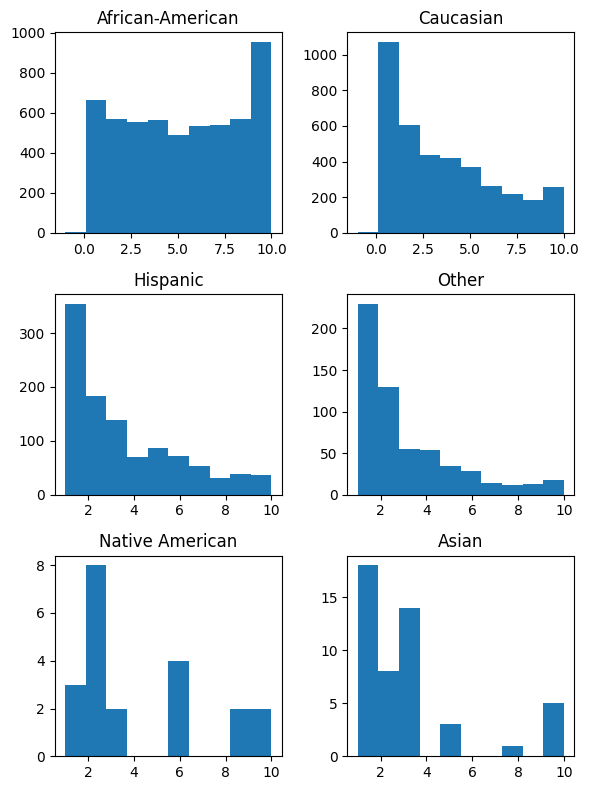

In [203]:
# Create plots for each race and their decile scores

races = syn_data_race['race'].unique()
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))

ax0.hist(syn_data_race[syn_data_race['race'] == races[0]]['decile_score'], 10)
# ax0.hist(compas[compas['race'] == races[0]]['decile_score'], 10, alpha=0.3)
ax0.set_title(races[0])

ax1.hist(syn_data_race[syn_data_race['race'] == races[1]]['decile_score'], 10)
# ax1.hist(compas[compas['race'] == races[1]]['decile_score'], 10, alpha=0.3)
ax1.set_title(races[1])

ax2.hist(syn_data_race[syn_data_race['race'] == races[2]]['decile_score'], 10)
# ax2.hist(compas[compas['race'] == races[2]]['decile_score'], 10, alpha=0.3)
ax2.set_title(races[2])

ax3.hist(syn_data_race[syn_data_race['race'] == races[3]]['decile_score'], 10)
# ax3.hist(compas[compas['race'] == races[3]]['decile_score'], 10, alpha=0.3)
ax3.set_title(races[3])

ax4.hist(syn_data_race[syn_data_race['race'] == races[4]]['decile_score'], 10)
# ax4.hist(compas[compas['race'] == races[4]]['decile_score'], 10, alpha=0.3)
ax4.set_title(races[4])

ax5.hist(syn_data_race[syn_data_race['race'] == races[5]]['decile_score'], 10)
# ax5.hist(compas[compas['race'] == races[5]]['decile_score'], 10, alpha=0.3)
ax5.set_title(races[5])

fig.tight_layout()
plt.show()

Focusing in on the African-American and Caucasian decile scores, we see that in our synthetic data that African-American defendants tend to have decile scores that are larger overall, while Caucasian decile scores tend to trend downwards.

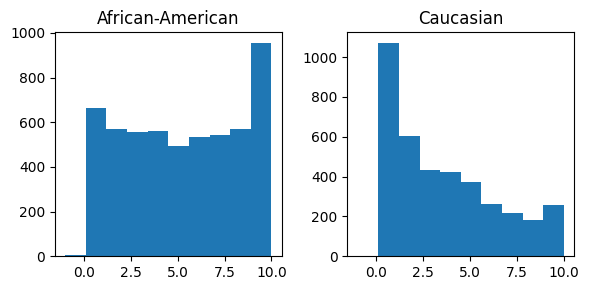

In [204]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax0.hist(syn_data_race[syn_data_race['race'] == 'African-American']['decile_score'], 10)
# ax0.hist(compas[compas['race'] == races[0]]['decile_score'], 10, alpha=0.3)
ax0.set_title('African-American')

ax1.hist(syn_data_race[syn_data_race['race'] == 'Caucasian']['decile_score'], 10)
# ax1.hist(compas[compas['race'] == races[1]]['decile_score'], 10, alpha=0.3)
ax1.set_title('Caucasian')

fig.tight_layout()
plt.show()